_This notebook is part of the material for the [ML Tutorials](https://github.com/NNPDF/como-2025) session._

# PDF Regression

In this tutorial we are going to utilize and expand on what you learned yesterday in the regression example.
We are going to apply the same techniques to the problem of PDF fitting.

#### In this tutorial

We start by fitting a known PDF (as given by LHAPDF) for a fixed scale.
We start with a naive neural network (although already tuned to our problem) to get an approximation of the pdf itself.

Then we will apply some physical constraints to the result for which we cannot use the ready-made ML tools given by `tensorflow`.
And we will preprocess the input to avoid saturation due to the different scales of the input.

Finally we will complicate a bit more the fit by adding fitting all partons at the same time.


This, however, cannot be applied directly to the problem of PDF fitting due to two main reasons:

1. The PDF is not a quantity we can measure experimentally. Therefore we need a way to map our PDFs to experimental data.
2. The experimental data has some uncertainties associated to it, therefore we need a way to propagate that information into the PDF fit.

These two issues will be tackled in the next tutorial

In [1]:
from collections import defaultdict

import numpy as np
import tensorflow as tf
from lhapdf import mkPDF
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

tf.keras.backend.clear_session()

## Fitting a PDF

We are going to use the `lhapdf` library and the `NNPDF40_nnlo_as_01180` PDF set. We start by reading a large number of points that we will use to train the network later on.

### Reading the data

In [2]:
pdf_set = "NNPDF40_nnlo_as_01180"
pdf_target = mkPDF(pdf_set)


def pid_to_latex(pid):
    """Function to translate the PID number into latex values, useful for plotting"""
    translate = {21: "g", 1: "d", 2: "u", 3: "s", 4: "c", 5: "b", 6: "t"}
    flav = translate[abs(pid)]
    if pid < 0:
        flav = rf"\bar{{{flav}}}"
    return flav

LHAPDF 6.5.5 loading /Users/roy/miniconda3/envs/env_como/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [3]:
q0 = 1.65  # Reference scale
npoints = int(5e4)  # How many points to use for training
xgrid = np.concatenate([np.logspace(-5, -1, npoints // 2), np.linspace(0.1, 1, npoints // 2)])
pdf_grid_all = pdf_target.xfxQ2(xgrid, np.ones_like(xgrid) * q0**2)

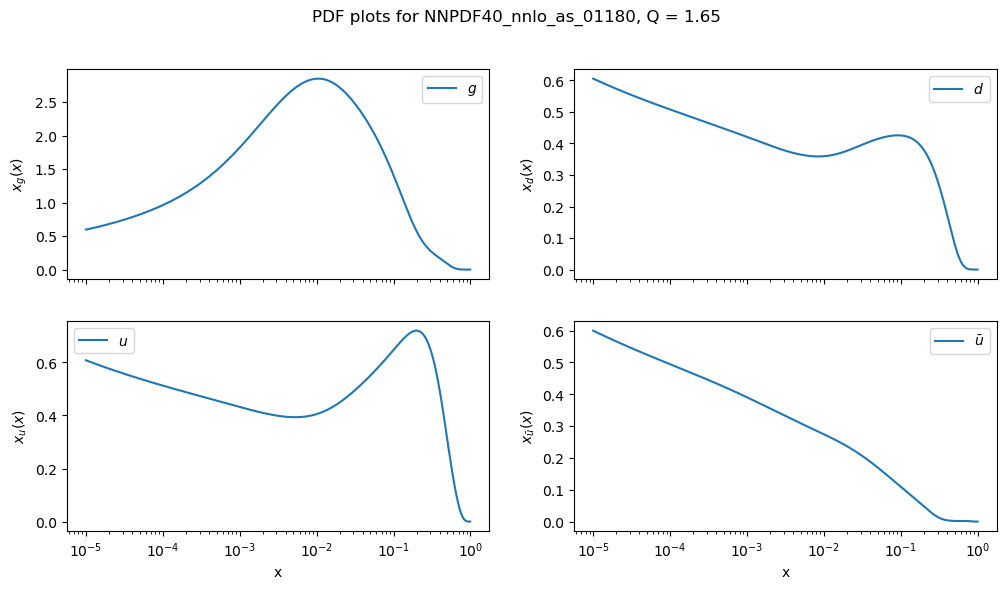

In [4]:
# Let's plot a few PDFs to see how they look

# Let's select only a few flavours
flavour_select = [21, 1, 2, -2]
pdf_grid = defaultdict(list)

# Take only a subset of values for the plot (otherwise it might be too heavy in memory!)
for point in pdf_grid_all[::200]:
    for pid in flavour_select:
        pdf_grid[pid_to_latex(pid)].append(point[pid])

fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.suptitle(f"PDF plots for {pdf_set}, Q = {q0}")
for i, (parton, val) in enumerate(pdf_grid.items()):
    plt.subplot(2, 2, i + 1)

    plt.plot(xgrid[::200], val, label=f"${parton}$")
    plt.legend()
    plt.xscale("log")
    if i > 1:
        plt.xlabel("x")
    plt.ylabel(f"$x_{{{parton}}}(x)$")

### NN - PDF

In [5]:
def generate_model(outputs=1, input_layer=None, nlayers=3, units=14, activation="tanh"):
    """
    Create a tensorflow sequential model where all intermediate layers have the same size
    This function accepts an already constructed layer as the input.

    All hidden layers will have the same number of nodes for simplicity

    Arguments:
        outputs: int (default=1)
                number of output nodes (how many flavours are we training)
        input_layer: KerasTensor (default=None)
                if given, sets the input layer of the sequential model
        nlayers: int
                number of hidden layers of the network
        units: int
                number of nodes of every hidden layer in the network
        activation: str
                activation function to be used by the hidden layers (ex: 'tanh', 'sigmoid', 'linear')
    """
    model = Sequential(name="pdf")
    if input_layer is not None:
        model.add(input_layer)
    for _ in range(nlayers):
        model.add(keras.layers.Dense(units, activation=activation))
    model.add(keras.layers.Dense(outputs, activation="linear"))

    opt = keras.optimizers.Nadam()
    model.compile(opt, loss="mse")
    return model


pdf_model = generate_model()

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 2.0766


1.9028676748275757

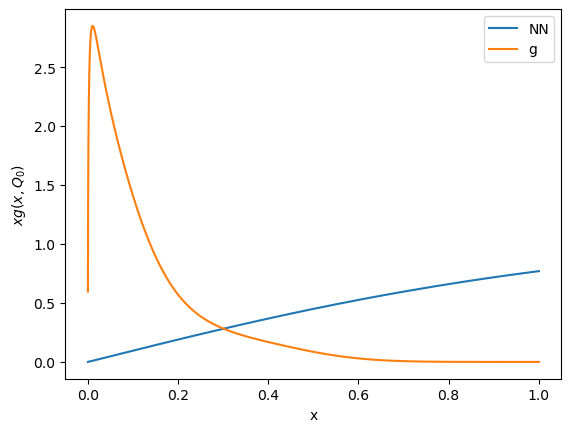

In [6]:
target_pid = 21
name = pid_to_latex(target_pid)

parton_data = np.array([pdf_grid[target_pid] for pdf_grid in pdf_grid_all])

# The tensorflow model expects the input to be (ndim, batch_size) in our case ndim = 1 (x)
input_xgrid = xgrid.reshape(-1, 1)


def compare_model(model, ivals, fval, label=name, evaluate=True, scale="linear"):
    """Compare the result of the model for a PDF with the target result"""
    vals = model(ivals)

    plt.plot(ivals, vals, label="NN")
    plt.plot(ivals, fval, label=label)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel(rf"$x{name}(x, Q_{0})$")
    plt.xscale(scale)

    if evaluate:
        return model.evaluate(ivals, fval)


compare_model(pdf_model, input_xgrid, parton_data)

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7205 - val_loss: 1.2380
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4694 - val_loss: 0.5741
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4598 - val_loss: 0.0196
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3491 - val_loss: 0.0125
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1091 - val_loss: 0.0103


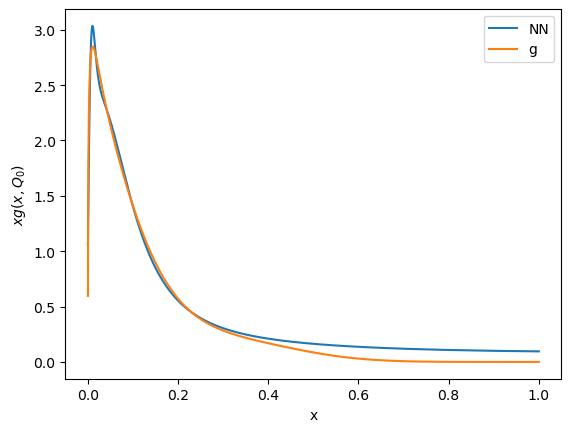

In [7]:
history = pdf_model.fit(input_xgrid, parton_data, epochs=5, validation_split=0.3)
compare_model(pdf_model, input_xgrid, parton_data, evaluate=False)

### Output preprocessing

While the results of the Neural Network are already quite good, they are not physically sound! How is that possible? Let's see what happens when we get close to x->1.0.

In [8]:
print(f"PDF result for f(x=1.0) = {pdf_target.xfxQ2(target_pid, 1.0, q0**2):.2}")
print(f"NN result for f(x=1.0) = {pdf_model(np.array([[1.0]])).numpy()[0,0]:.2}")

PDF result for f(x=1.0) = -3.3e-24
NN result for f(x=1.0) = 0.095


While it is possible for the Network to eventually learn that the value of the PDF in the limit $x\to1$ should be 0, it will take it a very long time to make it exactly 0 since the contribution to the loss will be very small.
However, since this is a bit of knowledge that we already have, we can process the output to ensure that we have a network that is equal to 0 when x=1!

In TensorFlow any model can also be utilized as a layer. We are going to use thus a more complicated api to construct the following preprocessed PDF:

\begin{equation}
    x\text{pdf}(x) = (1 - x)^{\beta}\text{NN}(x)
\end{equation}

#### Creating custom layers (fixed $\beta$)

While the default layers included in TensorFlow and Keras are usually enough for most Machine Learning applications, sometimes it will be necessary to create custom operations.

For this example we are going to start by creating a very simple layer with no trainable parameters to apply the operation $(1-x)^{\beta}$ to our output, where we will fix the value of $\beta$.

In a subsequent step we will modify the custom layer to include also variable parameters.

Note that these are two fairly simple examples of what a custom layer can be, but you can make them as complicated as you want!

In [9]:
class FixedPreprocessing(tf.keras.layers.Layer):
    """This layer generates a preprocessing (1-x)**beta for a fixed value of beta"""

    def __init__(self, *args, beta=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self._beta = beta

    def call(self, x):
        return (1.0 - x) ** self._beta


# Since now the input will be shared by different layers, we are going to create a symbolic input layer
input_layer = tf.keras.layers.Input(shape=(1,))

# The next step is to create the ingredients of the fit
# 1. The PDF itself (we can reuse the same function as before)
# 2. The preprocessing layer
# 3. The multiplication of the preprocessing factor and the PDF itself

raw_pdf = generate_model(input_layer=input_layer)
fixed_preprocessing_factor = FixedPreprocessing(beta=1.0)
multiplicative_layer = tf.keras.layers.Multiply()

final_result = multiplicative_layer([raw_pdf(input_layer), fixed_preprocessing_factor(input_layer)])

# Once we have built the entire path, we can now create a model out of it
pdf_model_preprocessed = tf.keras.models.Model(input_layer, final_result)
opt = keras.optimizers.Nadam()
pdf_model_preprocessed.compile(opt, loss="mse")

In [10]:
# If we inspect the full model, we can see that the PDF model has been compressed as a layer of the full model
pdf_model_preprocessed.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pdf (Sequential)    │ (None, 1)         │        463 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fixed_preprocessing │ (None, 1)         │          0 │ input_layer_1[0]… │
│ (FixedPreprocessin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ pdf[0][0],        │
│                     │                   │            │ fixed_preprocess… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 463 (1.81 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print(f"NN result for f(x=1.0) = {pdf_model_preprocessed(np.array([[1.0]])).numpy()[0,0]:.2}")

NN result for f(x=1.0) = 0.0


Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7579 - val_loss: 0.0521
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4673 - val_loss: 0.0373
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4533 - val_loss: 0.0016
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2498 - val_loss: 0.0015
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0667 - val_loss: 0.0021


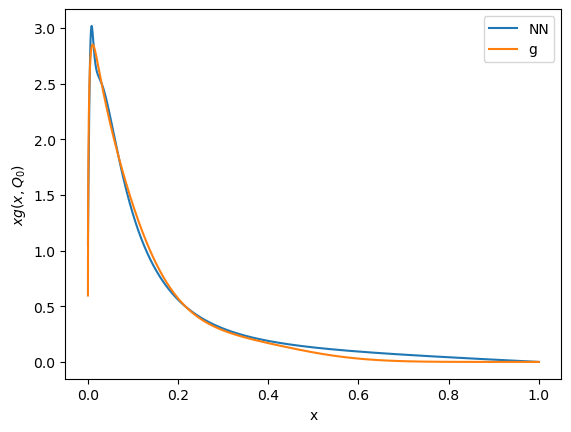

In [12]:
history = pdf_model_preprocessed.fit(input_xgrid, parton_data, epochs=5, validation_split=0.3)
compare_model(pdf_model_preprocessed, input_xgrid, parton_data, evaluate=False)

#### Creating custom layers (trainable $\beta$)

Now let's repeat the same exercise, but for a variable value of the exponent $\beta$.


Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.7113 - val_loss: 0.0018
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4709 - val_loss: 0.0155
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3431 - val_loss: 0.0089
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1205 - val_loss: 0.0017
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0411 - val_loss: 6.3856e-04


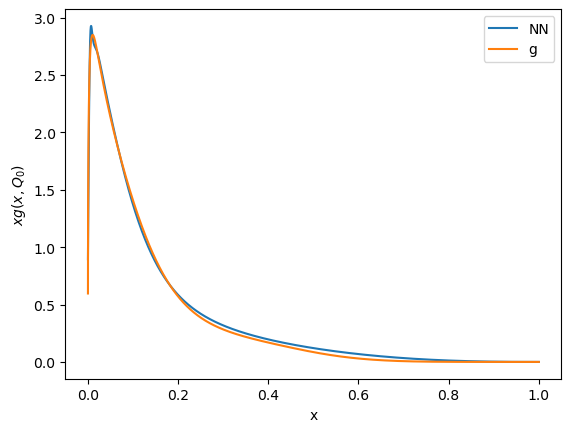

In [13]:
class Preprocessing(tf.keras.layers.Layer):
    """This layer generates a preprocessing (1-x)**(1+beta)"""

    def build(self, input_shape):
        """The build function will be called before a forward pass and the trainable weight
        will be generated. Beta is constrained to be a positive value to avoid 1/0"""
        self._beta = self.add_weight(
            shape=(1,), trainable=True, name="beta", constraint=tf.keras.constraints.non_neg()
        )

    def call(self, x):
        return (1.0 - x) ** (self._beta + 1.0)


# Since we are only going to change the preprocessing layer we can in principle reutilize all others.
# but since we already trained the PDF we are going to regenerate it to reset all weights
raw_pdf = generate_model(input_layer=input_layer)
preprocessing_factor = Preprocessing()

final_result = multiplicative_layer([raw_pdf(input_layer), preprocessing_factor(input_layer)])

# Once we have built the entire path, we can now create a model out of it
pdf_model_preprocessed = tf.keras.models.Model(input_layer, final_result)
opt = keras.optimizers.Nadam()
pdf_model_preprocessed.compile(opt, loss="mse")
history = pdf_model_preprocessed.fit(input_xgrid, parton_data, epochs=5, validation_split=0.3)
compare_model(pdf_model_preprocessed, input_xgrid, parton_data, evaluate=False)

In [14]:
print(f"NN result for f(x=1.0) = {pdf_model_preprocessed(np.array([[1.0]])).numpy()[0,0]:.2}")

NN result for f(x=1.0) = 0.0


### The small-x behaviour

If you are familiar with PDFs you might be wondering why are we looking at the large-x behaviour of the PDF when most of the PDF contribution (specially for the gluon) is concentrated at small x. Let's see how our model behaved at small x values of by plotting it with a log scale.

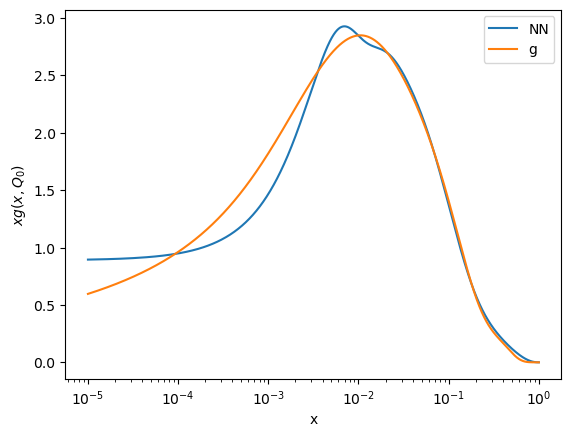

In [15]:
compare_model(pdf_model_preprocessed, input_xgrid, parton_data, evaluate=False, scale="log")

The behaviour at small x is quite wrong! Despite the fact that we generated half of the data logarithmically at small x precisely to make sure that we had enough data to train this region.

In addition to that, we are seeing that the behaviour of the network is quite flat. This is a common problem when the input data involves different scales and which require some form of preprocessing of the input.

Text(0, 0.5, 'N')

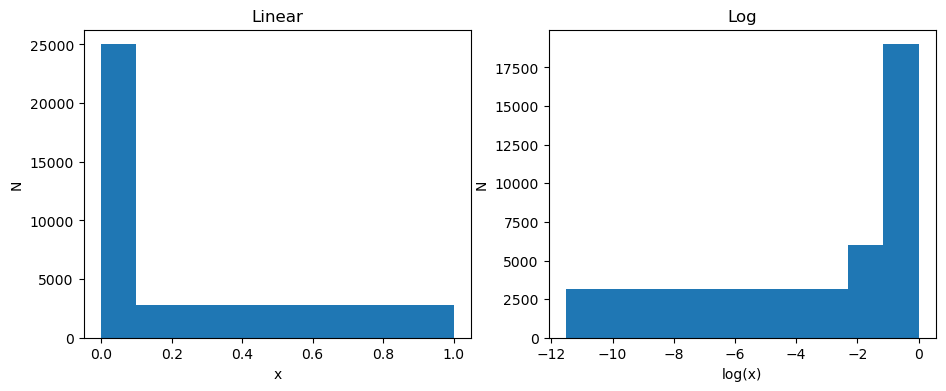

In [16]:
c, b = np.histogram(xgrid)
cl, bl = np.histogram(np.log(xgrid))

plt.subplots(1, 2, figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Linear")
plt.stairs(c, b, fill=True)
plt.xlabel("x")
plt.ylabel("N")
plt.subplot(1, 2, 2)
plt.title("Log")
plt.stairs(cl, bl, fill=True)
plt.xlabel("log(x)")
plt.ylabel("N")

In this particular, case since we know the approximate scaling of the input, we are going to exploit said knowledge by passing the linear in x and logarithmic in x behaviour as two different dimensions of the input.

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4634 - val_loss: 0.0015
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.8037e-04 - val_loss: 5.1069e-04
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5305e-04 - val_loss: 1.3342e-04
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7553e-04 - val_loss: 3.6719e-05
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4416e-04 - val_loss: 1.2420e-04


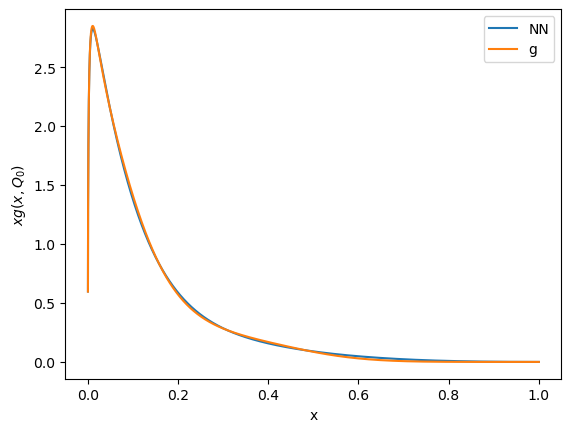

In [17]:
class InputScaling(tf.keras.layers.Layer):
    """This layer applies a logarithmic scaling to the input and then concatenates it to the actual input
    This layer is dim=1 --> dim=2
    """

    def call(self, x):
        return tf.concat([x, tf.math.log(x)], axis=-1)


scaled_input = InputScaling()

# We are going to regenerate the PDF, for which now the input layer will be the InputScaling
# the PDF function (before preprocessing factor) is then: (x) -> (x, log(x)) -> NN(x, log(x))

raw_pdf = generate_model(input_layer=scaled_input)
preprocessing_factor = Preprocessing()

# All other steps are the same as before, we could even reutilize the preprocessing we already have!
final_result = multiplicative_layer([raw_pdf(input_layer), preprocessing_factor(input_layer)])
pdf_model_final = tf.keras.models.Model(input_layer, final_result)

opt = keras.optimizers.Nadam()
pdf_model_final.compile(opt, loss="mse")
history = pdf_model_final.fit(input_xgrid, parton_data, epochs=5, validation_split=0.3)
compare_model(pdf_model_final, input_xgrid, parton_data, evaluate=False)

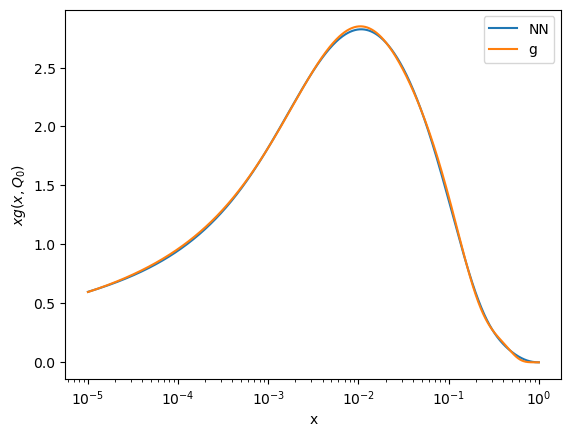

In [18]:
compare_model(pdf_model_final, input_xgrid, parton_data, evaluate=False, scale="log")

In [19]:
pdf_model_final.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pdf (Sequential)    │ (None, 1)         │        477 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_1     │ (None, 1)         │          1 │ input_layer_1[0]… │
│ (Preprocessing)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ pdf[0][0],        │
│                     │                   │            │ preprocessing_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,437 (5.62 KB)

 Trainable params: 478 (1.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 959 (3.75 KB)

### Multiflavour fit

In reality the proton is not made only of gluons and indeed all flavours do contribute to it. Let's utilize what we  know to do a fit for all flavours at the same time. At the fitting scale that we are using only 9 partons are active: u, d, c, s and their antiparticles plus the gluon.

The input is still one dimensional (x) which will become 2-dimensional when we apply the log preprocessing. The output instead is now 9-dimensional.

In [20]:
# Prepare the output data
output_basis = [-4, -3, -2, -1, 21, 1, 2, 3, 4]
noutput = len(output_basis)
output_data = np.zeros((len(pdf_grid_all), noutput))
for i, pdf_grid in enumerate(pdf_grid_all):
    for j, pid in enumerate(output_basis):
        output_data[i, j] = pdf_grid[pid]
output_data = np.array(output_data)
output_data.shape

(50000, 9)

In [21]:
# Let us create the whole model again with the necessary changes:

# The input hasn't changed, still x -> (x, log(x))
input_layer = tf.keras.layers.Input(shape=(1,))
scaled_input = InputScaling()

# The PDF model, instead, needs to be able to output 9 flavours at once!
raw_pdf_multiflavour = generate_model(outputs=noutput, input_layer=scaled_input, nlayers=4)

# In principle we could have a preprocessing factor per output, but let's utilize the same one for all
single_preprocessing = Preprocessing()
mm_layer = tf.keras.layers.Multiply()

final_result = mm_layer([raw_pdf_multiflavour(input_layer), single_preprocessing(input_layer)])
pdf_model_multiflavour = tf.keras.models.Model(input_layer, final_result)


pdf_model_multiflavour.compile(keras.optimizers.Nadam(), loss="mse")
history = pdf_model_multiflavour.fit(input_xgrid, output_data, epochs=15, validation_split=0.3)

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0625 - val_loss: 2.0301e-04
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.9993e-04 - val_loss: 1.4450e-04
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8001e-04 - val_loss: 1.5733e-04
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0797e-04 - val_loss: 1.4859e-04
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5476e-05 - val_loss: 1.3826e-04
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4914e-05 - val_loss: 1.3662e-04
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3818e-05 - val_loss: 1.2686e-04
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2233e-05 - val_loss: 1.2205e-04
Epoch 9/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.3593e-05 - val_loss: 1.0948e-04
Epoch 10/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1976e-05 - val_loss: 9.8205e-05
Epoch 11/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 

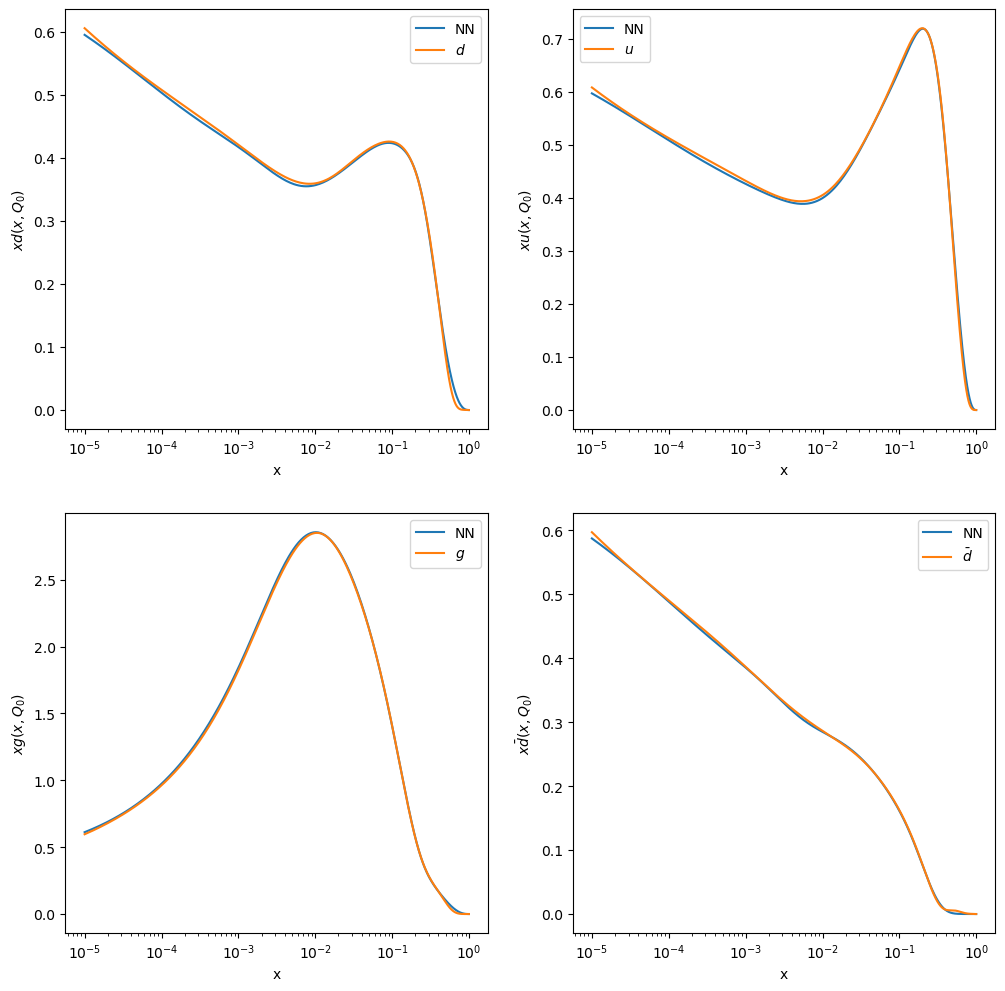

In [22]:
step = 100
reduced_xgrid = input_xgrid[::step]
model_values = pdf_model_multiflavour(reduced_xgrid).numpy()
lhapdf_values = output_data[::step]

plt.subplots(2, 2, figsize=(12, 12))

for i, pid in enumerate([1, 2, 21, -1]):
    idx = output_basis.index(pid)
    name = pid_to_latex(pid)

    plt.subplot(2, 2, i + 1)

    plt.plot(reduced_xgrid[:, 0], model_values[:, idx], label="NN")
    plt.plot(reduced_xgrid[:, 0], lhapdf_values[:, idx], label=f"${name}$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel(rf"$x{name}(x, Q_{0})$")
    plt.xscale("log")

### Piquing your interest: hyperparameter selection

In all these examples we have used a Neural Network that is able to give you a good looking PDF amazingly fast. However, when you tackle machine learning problem you will often find that the first few attemps are quite underwhelming.

The secret ingredient is in the selection of hyperparameters. Let's look at the definition of the function:

```python
def generate_model(..., nlayers=3, units=16, activation="tanh"):
```

In the definition of the function I've set a few defaults which were already tuned to the PDF fit.

- `nlayers` is the number of hidden layers
- `units` is the number of nodes that each one of these layers will have (all the same, for simplicity)
- `activation` activation function at the end of every layer y = activation( Ax + b)

And this is just a subset of the possible hyperparameters! For instance, we are utilizing always the same optimizer with the default values ([tf optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/)). We have also set all hidden layers to be fully-connected dense layers with the same number of units and activation functions for a very simple architecture. But we will see that even with a simple architecture the choice of hyperparameters can have a really big effect on the final results.

Let's try to do a new fit just like the one above but changing some of these numbers.

In [23]:
def run_fit_wrapper(
    raw_pdf, input_xgrid=input_xgrid, input_layer=input_layer, parton_data=parton_data, epochs=5
):
    """Wrapper to run a 5-epoch fit and produce a plot given a raw pdf model
    Note that we reutilize the information from the previous cells in order to prepare this one
    """
    preprocessing_factor = Preprocessing()
    multiplicative_layer = tf.keras.layers.Multiply()
    final_result = multiplicative_layer([raw_pdf(input_layer), preprocessing_factor(input_layer)])

    pdf_model = tf.keras.models.Model(input_layer, final_result)

    opt = keras.optimizers.Nadam()
    pdf_model.compile(opt, loss="mse")

    history = pdf_model.fit(input_xgrid, parton_data, epochs=epochs, validation_split=0.3)
    compare_model(pdf_model, input_xgrid, parton_data, evaluate=False)
    return pdf_model

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.7370 - val_loss: 0.0204
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2655 - val_loss: 5.6226e-06
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0887 - val_loss: 2.3877e-05
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0160 - val_loss: 1.2976e-04
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 1.3625e-04


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pdf (Sequential)    │ (None, 1)         │          9 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_3     │ (None, 1)         │          1 │ input_layer_3[0]… │
│ (Preprocessing)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1)         │          0 │ pdf[0][0],        │
│ (Multiply)          │                   │            │ preprocessing_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23 (96.00 B)

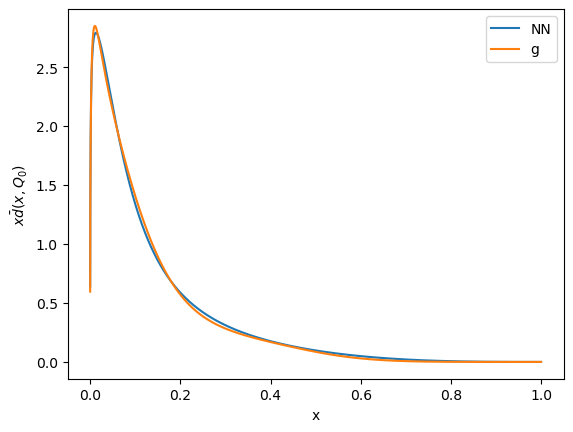

In [24]:
# Example 1: too small number of parameters
raw_pdf = generate_model(input_layer=scaled_input, nlayers=1, units=2)
model = run_fit_wrapper(raw_pdf)
model.summary()

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6329 - val_loss: 0.0856
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0658 - val_loss: 0.0475
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0487 - val_loss: 0.0186
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0392 - val_loss: 0.0091
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0335 - val_loss: 0.0047


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pdf (Sequential)    │ (None, 1)         │        477 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_4     │ (None, 1)         │          1 │ input_layer_3[0]… │
│ (Preprocessing)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1)         │          0 │ pdf[0][0],        │
│ (Multiply)          │                   │            │ preprocessing_4[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,437 (5.62 KB)

 Trainable params: 478 (1.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 959 (3.75 KB)

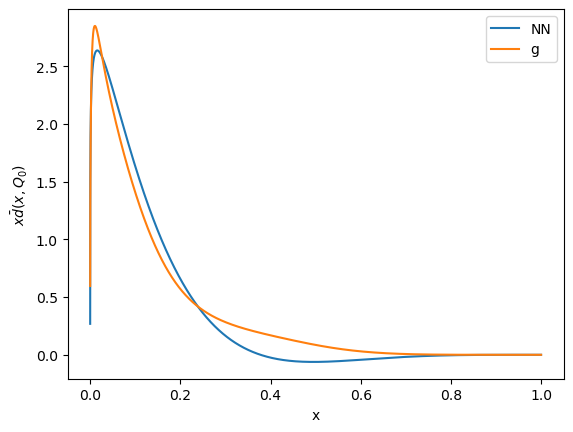

In [25]:
# Example 2: not enough complexity
raw_pdf = generate_model(input_layer=scaled_input, activation="linear")
model = run_fit_wrapper(raw_pdf)
model.summary()

Epoch 1/2
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.7068 - val_loss: 0.0071
Epoch 2/2
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.4850 - val_loss: 0.0018


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pdf (Sequential)    │ (None, 1)         │  1,251,073 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_5     │ (None, 1)         │          1 │ input_layer_3[0]… │
│ (Preprocessing)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 1)         │          0 │ pdf[0][0],        │
│ (Multiply)          │                   │            │ preprocessing_5[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,753,225 (14.32 MB)

 Trainable params: 1,251,074 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,502,151 (9.54 MB)

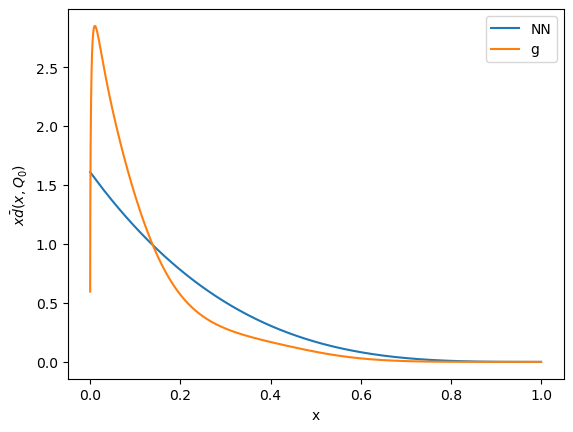

In [26]:
# Example 3: why cannot we be safe and just use a very large number of parameters?
raw_pdf = generate_model(input_layer=scaled_input, nlayers=20, units=256)
model = run_fit_wrapper(raw_pdf, epochs=2)
model.summary()